## Whales recognition ResNet baseline

In [13]:
from fastai import *
from fastai.vision import *

from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math

MODEL_NAME = 'Resnet50'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS = 'data/train.csv'
SAMPLE_SUB = 'data/sample_submission.csv'

# Backbone architecture
arch = 'resnet50'
# Number of workers for data preprocessing
num_workers = 4

ModuleNotFoundError: No module named 'fastai.conv_learner'

Next, we prapare out dataset to work with Fastai's pipeline.

In [5]:
train_df = pd.read_csv(LABELS).set_index('Image')
unique_labels = np.unique(train_df.Id.values)

labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)
test_names = [f for f in os.listdir(TEST)]

Number of classes: 5005


Let's draw a simple histogram to see the sample-per-class distribution.

Count for class new_whale: 9664


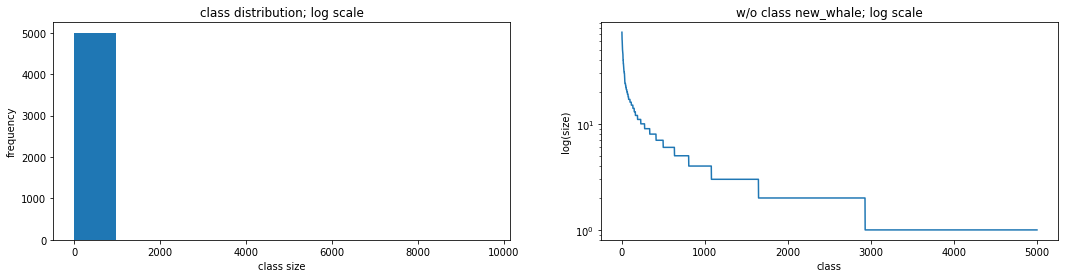

In [6]:
labels_count = train_df.Id.value_counts()

plt.figure(figsize=(18, 4))
plt.subplot(121)
_, _,_ = plt.hist(labels_count.values)
plt.ylabel("frequency")
plt.xlabel("class size")

plt.title('class distribution; log scale')
labels_count.head()

print("Count for class new_whale: {}".format(labels_count[0]))
plt.subplot(122)
_ = plt.plot(labels_count[1:].values)
plt.title('w/o class new_whale; log scale')
plt.xlabel("class")
plt.ylabel("log(size)")
plt.gca().set_yscale('log')

In [9]:
train_df['image_name'] = train_df.index

rs = np.random.RandomState(747)
perm = rs.permutation(len(train_df))

tr_n = train_df['image_name'].values
# Validate on the subset of training data
val_n = train_df['image_name'].values[perm][:1000]

print('Train/val:', len(tr_n), len(val_n))
print('Train classes', len(train_df.loc[tr_n].Id.unique()))
print('Val classes', len(train_df.loc[val_n].Id.unique()))

Train/val: 25361 1000
Train classes 5005
Val classes 541


In [10]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']

    def get_c(self):
        return len(unique_labels)


NameError: name 'FilesDataset' is not defined

In [11]:
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b, self.c = b, c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x  # add this line to fix the bug
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1 / (c - 1) if c < 0 else c + 1
        x = lighting(x, b, c)
        return x
    
def get_data(sz, batch_size):
    """
    Read data and do augmentations
    """
    aug_tfms = [RandomRotateZoom(deg=25, zoom=2, stretch=1),
                RandomLighting(0.2, 0.2, tfm_y=TfmType.NO),
                RandomBlur(blur_strengths=3,tfm_y=TfmType.NO),
                RandomFlip(tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % batch_size)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, batch_size, num_workers=num_workers, classes=None)
    return md


NameError: name 'TfmType' is not defined

In [12]:
image_size = 224
batch_size = 96
md = get_data(image_size, batch_size)
extra_fc_layers_size = []
learn = ConvLearner.pretrained(arch, md, xtra_fc=extra_fc_layers_size) 
learn.opt_fn = optim.Adam

NameError: name 'get_data' is not defined

In [ ]:
print('Number of layer groups:', len(learn.get_layer_groups()), '\t(first 2 groups is pretrained backbone)')
print('This is our extra thin on top of the backbone Resnet50 architecture:')
learn.get_layer_groups()[2]

# Nothing fancy, just train in here
We start by training only the newly initialized weights (classifier), then unfreeze the model and finetune the pretrained weights

In [ ]:
base_lr = 1e-4 # lr for the backbone
fc_lr = 1e-3 # lr for the classifer

lrs = [base_lr, base_lr, fc_lr]
# Freeze backbone and train the classifier for 2 epochs
learn.fit(lrs=lrs, n_cycle=2, cycle_len=None)

# Unfreeze backbone and continue training for 9 epochs
learn.unfreeze()
learn.fit(lrs, n_cycle=38, cycle_len=None)

## No Fuss Prediction with 8 TTA

In [ ]:
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)

Finally, our submission.

In [ ]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission_{}.csv'.format(MODEL_NAME), header=True, index=False)
df.head()